# Identification of Key genes in Dex stimulation


In [ ]:
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
adata_a12_raw = sc.read_text('/home/formanj/Desktop/UpDown_Project/Datasets/DUSP1/A1-2_sc_Bulk_GSE141834/GSE141834_scRNAseq_rawCounts.txt').T
adata_a12_norm = sc.read_text("/home/formanj/Desktop/UpDown_Project/Datasets/DUSP1/A1-2_sc_Bulk_GSE141834/GSE141834_scRNAseq_seuratV3_normalized.txt").T
adata_a12_bulk = sc.read_text('/home/formanj/Desktop/UpDown_Project/Datasets/DUSP1/A1-2_sc_Bulk_GSE141834/GSE141834_bulkRNAseq_normalized_counts.txt').T
adata_u2os = sc.read_csv("/home/formanj/Desktop/UpDown_Project/Datasets/DUSP1/U2OS_s4U_GSE/GSE216337_4su_exon_stranded_counts.csv").T

# Preprocessing
A1-2 Raw Counts

In [ ]:
adata_a12_raw

In [ ]:
# Identify groups and timepoints
adata_a12_raw.obs['timepoint'] = [x.split('.')[1] for x in adata_a12_raw.obs_names]
adata_a12_raw.obs['treatment'] = [x.split('.')[0] for x in adata_a12_raw.obs_names]

adata_a12_raw.obs['timepoint'] = adata_a12_raw.obs['timepoint']
adata_a12_raw.obs['treatment'] = adata_a12_raw.obs['treatment'].astype('category')


adata_a12_raw.obs['timepoint'] = [int(i) for i in adata_a12_raw.obs['timepoint']]


In [ ]:
adata_a12_raw.obs

In [ ]:
# Remove non dex stimulated groups
adata_a12_raw = adata_a12_raw[adata_a12_raw.obs['treatment'] == 'Dex']

In [ ]:
# gets all the timepoints into uns dataframe
adata_a12_raw.uns['timepoint'] = set(adata_a12_raw.obs['timepoint'])
adata_a12_raw.uns['timepoint'] = list(adata_a12_raw.uns['timepoint'])
adata_a12_raw.uns['timepoint'].sort()

In [ ]:
# remove excess genes
print(adata_a12_raw)
sc.pp.filter_genes(adata_a12_raw, min_counts=200)
print(adata_a12_raw)

A1-2 Normalized

In [ ]:
# Identify groups and timepoints
adata_a12_norm.obs['timepoint'] = [x.split('.')[1] for x in adata_a12_norm.obs_names]
adata_a12_norm.obs['treatment'] = [x.split('.')[0] for x in adata_a12_norm.obs_names]

adata_a12_norm.obs['timepoint'] = adata_a12_norm.obs['timepoint']
adata_a12_norm.obs['treatment'] = adata_a12_norm.obs['treatment'].astype('category')


adata_a12_norm.obs['timepoint'] = [int(i) for i in adata_a12_norm.obs['timepoint']]


In [ ]:
# Remove non dex stimulated groups
adata_a12_norm = adata_a12_norm[adata_a12_norm.obs['treatment'] == 'Dex']

In [ ]:
# gets all the timepoints into uns dataframe
adata_a12_norm.uns['timepoint'] = set(adata_a12_norm.obs['timepoint'])
adata_a12_norm.uns['timepoint'] = list(adata_a12_norm.uns['timepoint'])
adata_a12_norm.uns['timepoint'].sort()

A1-2 Bulk

In [ ]:
adata_a12_bulk.obs['dex_treatment'] = adata_a12_bulk.obs_names.str.startswith('D')
adata_a12_bulk = adata_a12_bulk[adata_a12_bulk.obs['dex_treatment']]

In [ ]:
adata_a12_bulk.obs['timepoint'] = [int(i[1:i.index('h')]) for i in adata_a12_bulk.obs_names]

In [ ]:
adata_a12_bulk.uns['timepoint'] = set(adata_a12_bulk.obs['timepoint'])
adata_a12_bulk.uns['timepoint'] = list(adata_a12_bulk.uns['timepoint'])
adata_a12_bulk.uns['timepoint'].sort()

U2OS s4U seq

In [ ]:
adata_u2os

In [ ]:
adata_u2os.obs

In [ ]:
adata_u2os.obs['treatment'] = adata_u2os.obs_names.str.startswith('W')

In [ ]:
adata_u2os = adata_u2os[adata_u2os.obs['treatment']]

In [ ]:
adata_u2os.obs['timepoint'] = [i[2] for i in adata_u2os.obs_names]

In [ ]:
"""from pybiomart import Dataset

dataset = Dataset(name='hsapiens_gene_ensembl',
                  host='http://www.ensembl.org')

dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])"""
# This no work 

Downsteam analysis

In [ ]:
print(adata_a12_raw)
print(adata_a12_norm)
print(adata_a12_bulk)
print(adata_u2os)

In [ ]:
list_genes = [i for i in adata_a12_raw.var_names 
                if (i in adata_a12_norm.var_names) and 
                (i in adata_a12_bulk.var_names)]

In [ ]:
len(list_genes)

In [ ]:
Datasets = [adata_a12_raw, adata_a12_norm, adata_a12_bulk]

dataset_names = {0: 'A1-2_Raw',
                1: 'A1-2_Norm',
                2: 'A1-2_Bulk'
                }
column_names = []
# set up average
for d in range(len(Datasets)):
    for tp in range(len(Datasets[d].uns['timepoint'])):
        column_names.append(dataset_names[d] + f'_tp_'+ str(Datasets[d].uns['timepoint'][tp]) + '_avg')

for d in range(len(Datasets)):
    for tp in range(0, len(Datasets[d].uns['timepoint'])-1):
        column_names.append(dataset_names[d] + f'_tp_'+ str(Datasets[d].uns['timepoint'][tp+1]) + '-' + str(Datasets[d].uns['timepoint'][tp]))


data = pd.DataFrame(columns=column_names, index=list_genes)

In [ ]:
# averages first
for g in range(len(list_genes)):
    for d in range(len(Datasets)):
        for tp in range(len(Datasets[d].uns['timepoint'])):
            column = dataset_names[d] + f'_tp_'+ str(Datasets[d].uns['timepoint'][tp]) + '_avg'
            data.loc[list_genes[g], column] = Datasets[d][Datasets[d].obs['timepoint'] == Datasets[d].uns['timepoint'][tp]][:, list_genes[g]].X.mean()



In [ ]:
# differences
for g in range(len(list_genes)):
    for d in range(len(Datasets)):
        for tp in range(len(Datasets[d].uns['timepoint'])-1):
            column = dataset_names[d] + f'_tp_'+ str(Datasets[d].uns['timepoint'][tp+1]) + '-' + str(Datasets[d].uns['timepoint'][tp])
            cname_0 = dataset_names[d] + f'_tp_'+ str(Datasets[d].uns['timepoint'][tp]) + '_avg'
            cname_1 = dataset_names[d] + f'_tp_'+ str(Datasets[d].uns['timepoint'][tp+1]) + '_avg'
            data.loc[list_genes[g], column] = data.loc[list_genes[g], cname_1] - data.loc[list_genes[g], cname_0] 

In [ ]:
for i in Datasets:
    print(i.uns['timepoint'])

In [ ]:
data.loc['CTSH', 'A1-2_Bulk_tp_1_avg']

In [105]:
import umap
import scipy.stats as stats

In [ ]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean'
)

In [ ]:
embedding = reducer.fit_transform(data.values)
embedding.shape

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=0.5)
plt.title('UMAP projection of Genes', fontsize=24)

In [ ]:
gene = 'DUSP1'
c_gene = np.ones(len(list_genes))
c_gene[list_genes.index(gene)] = 10

s_gene = np.ones(len(list_genes)) * 0.5
s_gene[list_genes.index(gene)] = 10

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=s_gene,
    c=c_gene,
    cmap='cool')
plt.title(f'UMAP projection of {gene}', fontsize=24)

In [ ]:
for col in data.columns:
    sc = plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=s_gene,
        c=data[col].values.flatten(),
        cmap='cool')
    plt.colorbar(sc)
    plt.title(col, fontsize=24)
    plt.show()

# Lets only look at changes

In [118]:
delta_data = data[[i for i in data.columns if 'avg' not in i]]

In [119]:
delta_data

A1-2_Raw_tp_1-0 A1-2_Raw_tp_2-1 A1-2_Raw_tp_4-2 A1-2_Raw_tp_8-4  \
CTSH           -0.1525            0.15          -0.015            0.04   
SFXN4             0.32           -0.07         -0.0675         -0.1125   
RBM45          -0.0125            0.04           -0.01          0.0625   
SCRN3           0.1125         -0.0425          -0.015            0.01   
NIPAL1          0.0225             0.0          -0.015           0.035   
...                ...             ...             ...             ...   
TBCE            0.3675          -0.025          -0.055           0.135   
HHEX            -0.005            0.03          0.0125           -0.02   
UTP11           0.1125          0.2225         -0.4075          0.3825   
INHBB           0.7075          0.2325          0.4175         -0.8125   
SLC6A3          0.0025           0.025          0.0475          0.1575   

       A1-2_Raw_tp_18-8 A1-2_Norm_tp_1-0 A1-2_Norm_tp_2-1 A1-2_Norm_tp_4-2  \
CTSH            -0.1325         -0.06089         0.039077         0.004459   
SFXN4            0.1225         0.055172        -0.022732        -0.006824   
RBM45            -0.105        -0.013551         0.008041         0.003754   
SCRN3            0.1625         0.021942        -0.010265         0.000007   
NIPAL1           -0.045         0.001727        -0.005154        -0.002131   
...                 ...              ...              ...              ...   
TBCE             0.0925         0.065062        -0.023088        -0.008672   
HHEX              0.055        -0.001046         0.004777         0.004337   
UTP11            0.3275        -0.004514         0.013641        -0.057665   
INHBB            0.0275         0.118475         0.007981         0.085715   
SLC6A3           0.0225         0.000798          0.00681         0.013059   

       A1-2_Norm_tp_8-4 A1-2_Norm_tp_18-8 A1-2_Bulk_tp_2-1 A1-2_Bulk_tp_4-2  \
CTSH          -0.005944         -0.033608        -0.070716         0.264503   
SFXN4           -0.0367          0.027945        -0.160909         0.209432   
RBM45          0.015924         -0.037931        -0.142706         0.186584   
SCRN3         -0.000977           0.03441         0.036232         -0.03759   
NIPAL1         0.013839          -0.01514        -0.257047         0.112453   
...                 ...               ...              ...              ...   
TBCE           0.045608         -0.010604        -0.142384         0.117253   
HHEX          -0.003673          0.008633         0.443544         0.287328   
UTP11          0.044987          0.054043         0.039578         0.265746   
INHBB         -0.147419           0.00192         0.415018         0.252136   
SLC6A3         0.037161          0.006448         3.201334         1.794035   

       A1-2_Bulk_tp_8-4 A1-2_Bulk_tp_18-8  
CTSH          -0.066588          -0.20692  
SFXN4          0.013894          0.001663  
RBM45         -0.084262          0.169132  
SCRN3         -0.083787          0.181215  
NIPAL1         0.593947         -0.301956  
...                 ...               ...  
TBCE          -0.211385          0.458997  
HHEX          -0.280319         -0.290829  
UTP11         -0.021649          0.058001  
INHBB         -0.486271         -0.558108  
SLC6A3         1.165689          0.409424  

[10892 rows x 14 columns]

In [120]:
reducer1 = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    metric='euclidean'
)

In [121]:
embedding1 = reducer1.fit_transform(delta_data.values)
embedding1.shape

(10892, 2)

Text(0.5, 1.0, 'UMAP projection of Genes')

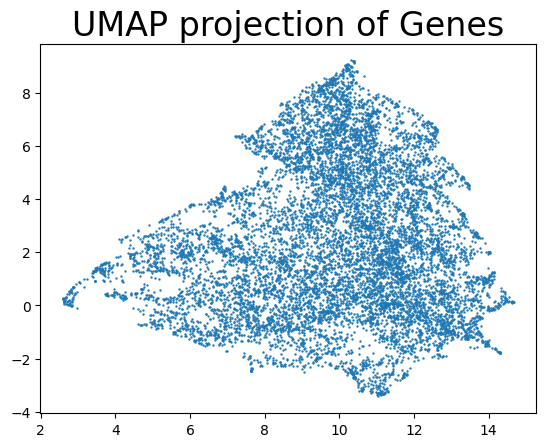

In [122]:
plt.scatter(
    embedding1[:, 0],
    embedding1[:, 1],
    s=0.5)
plt.title('UMAP projection of Genes', fontsize=24)

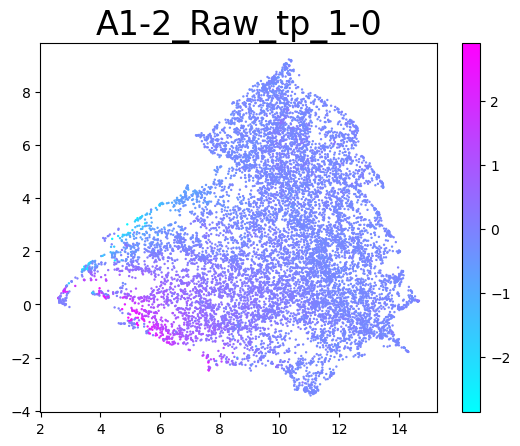

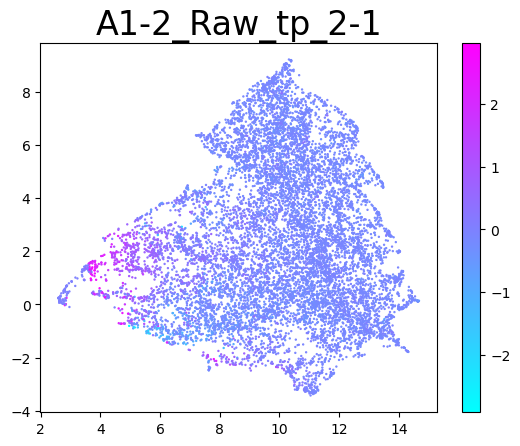

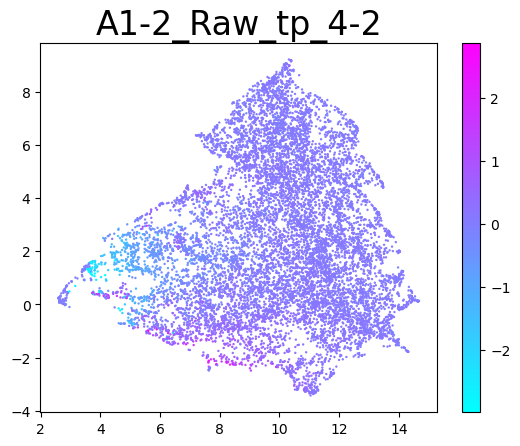

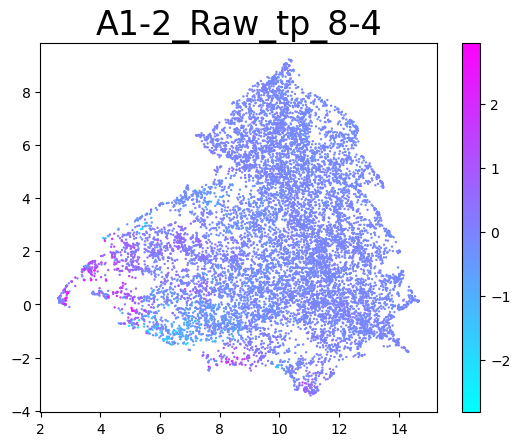

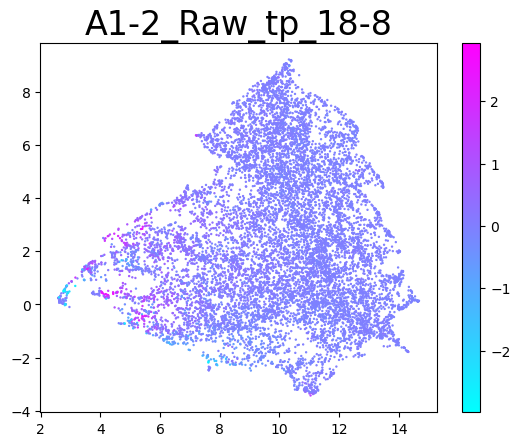

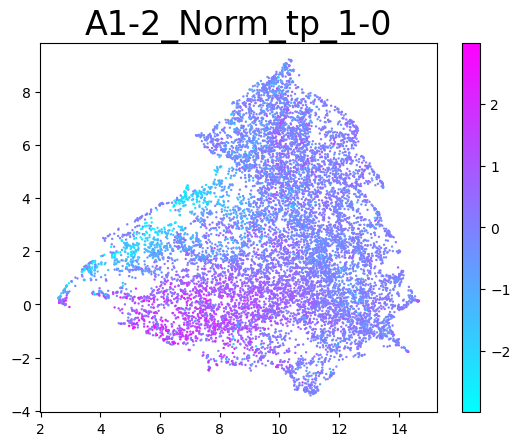

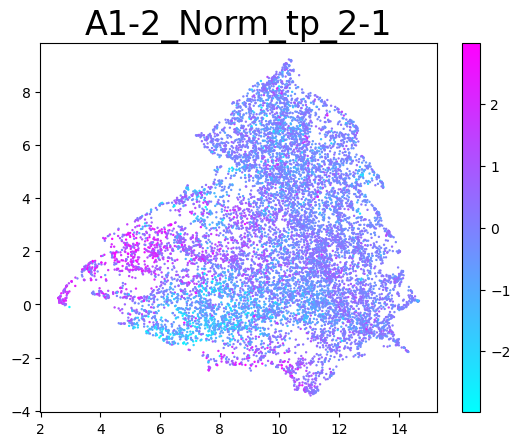

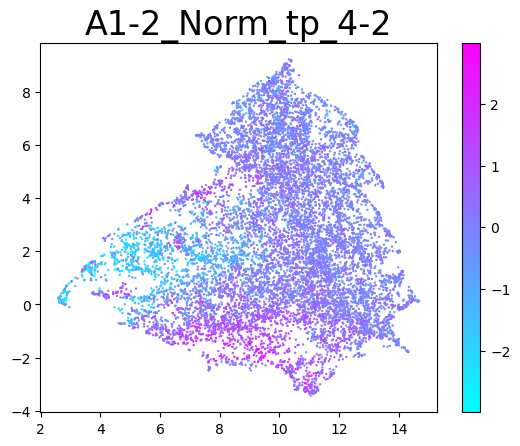

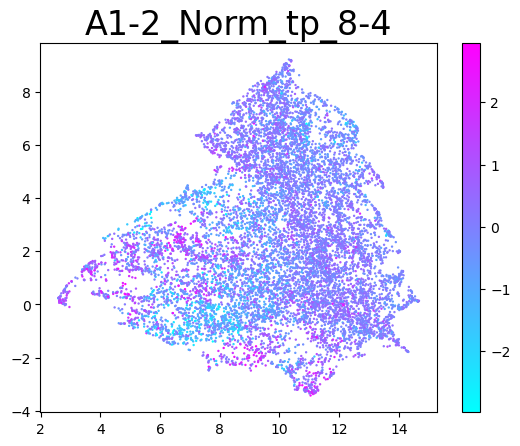

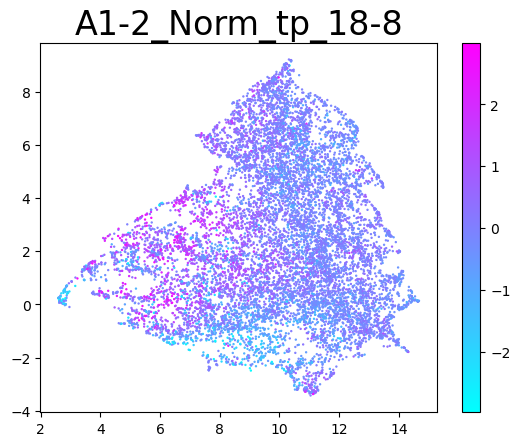

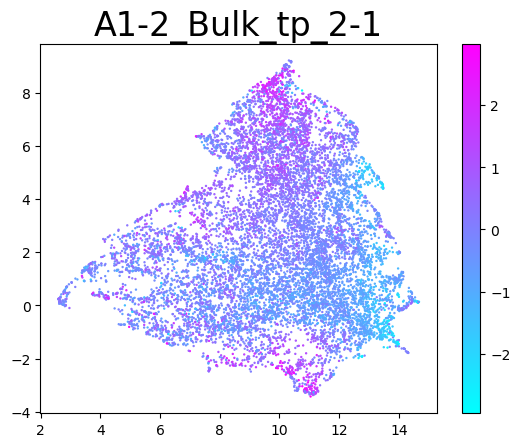

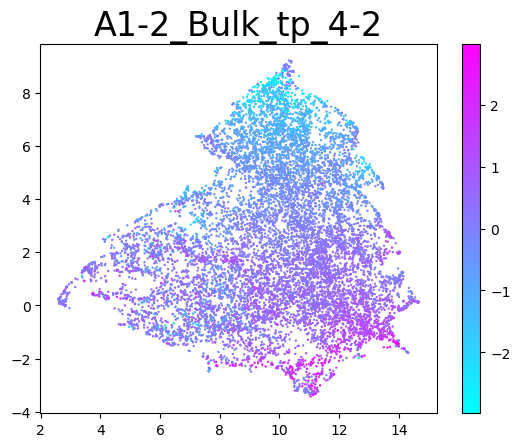

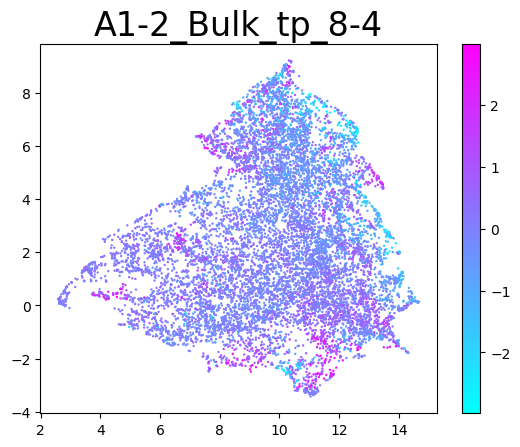

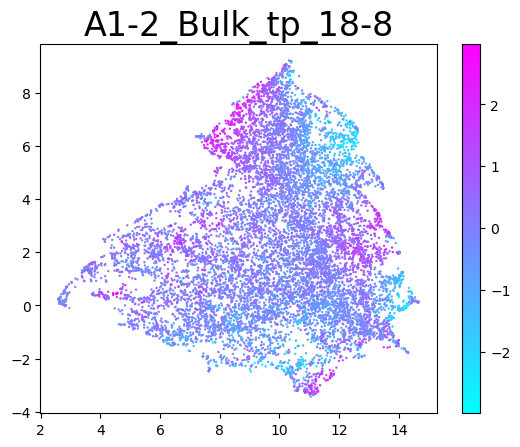

In [124]:
for col in delta_data.columns:
    c_map = stats.zscore(delta_data[col].values.astype(float))
    c_map[c_map > 3] = 0
    c_map[c_map < -3] = 0
    sc = plt.scatter(
        embedding1[:, 0],
        embedding1[:, 1],
        s=s_gene,
        c=c_map,
        cmap='cool')
    plt.colorbar(sc)
    plt.title(col, fontsize=24)
    plt.show()

TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable sqrt method

# Lets look at the raw data

In [115]:
raw_data = data[[i for i in data.columns if 'avg' in i]]

In [127]:
reducer2 = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    metric='euclidean'
)

In [128]:
embedding2 = reducer2.fit_transform(raw_data.values)
embedding2.shape

(10892, 2)

Text(0.5, 1.0, 'UMAP projection of Genes')

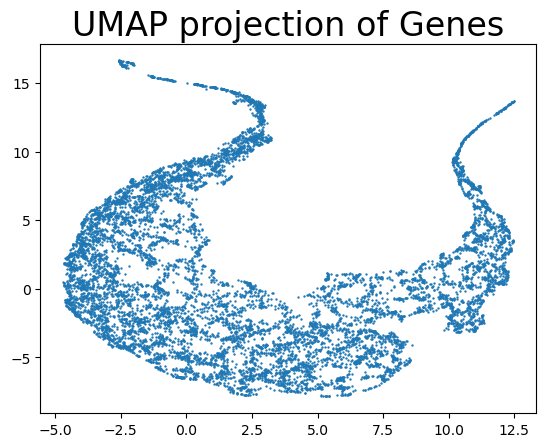

In [129]:
plt.scatter(
    embedding2[:, 0],
    embedding2[:, 1],
    s=0.5)
plt.title('UMAP projection of Genes', fontsize=24)

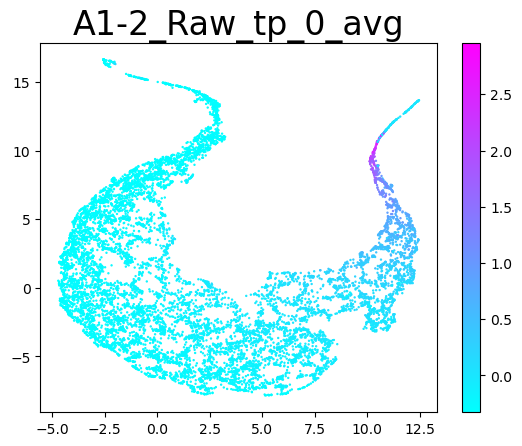

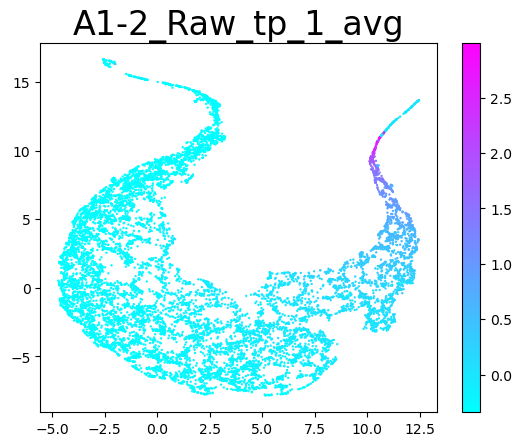

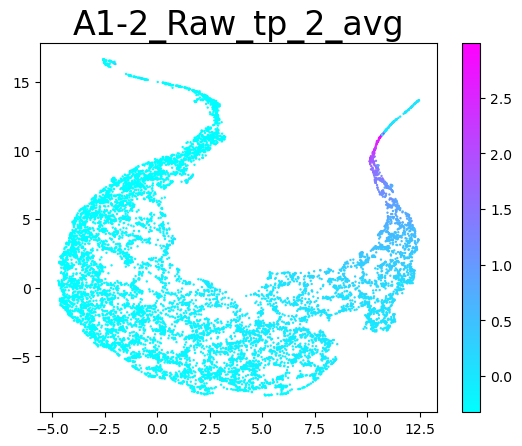

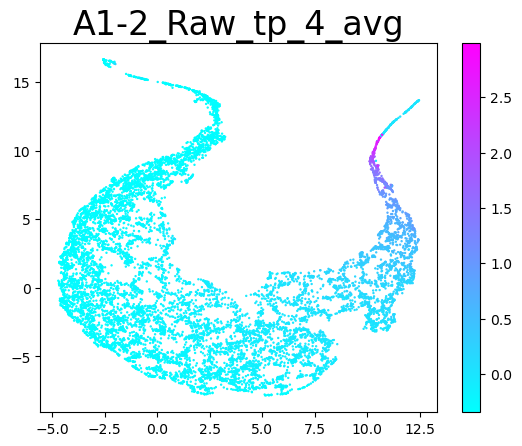

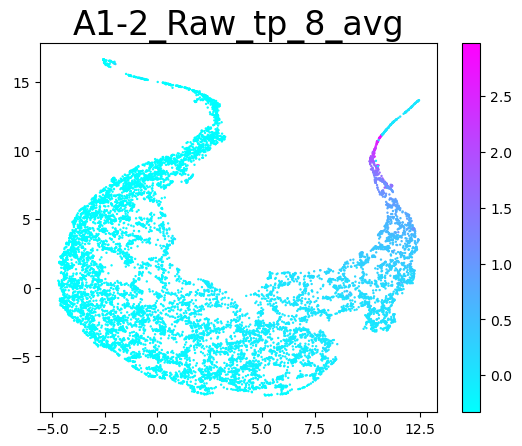

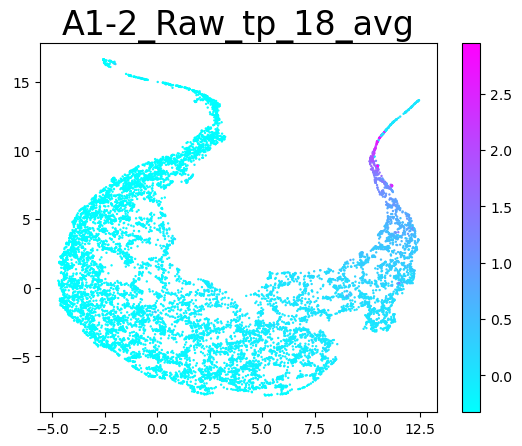

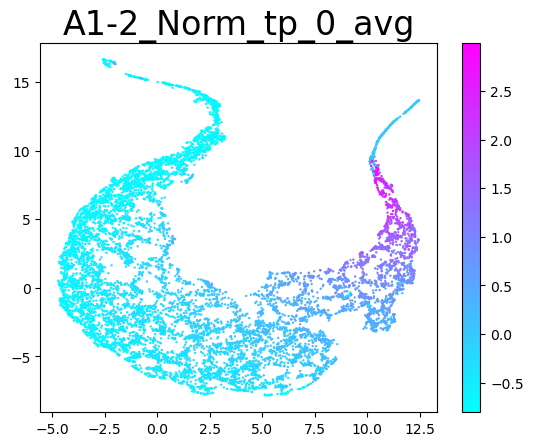

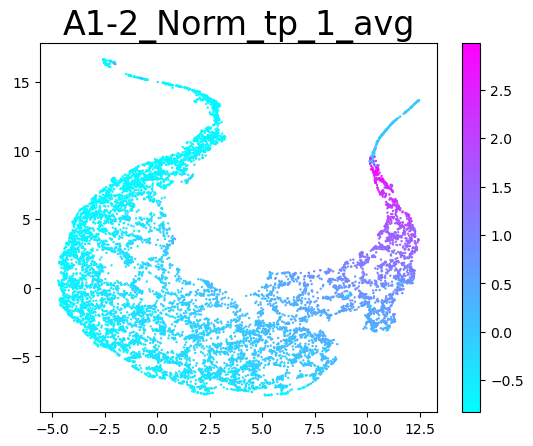

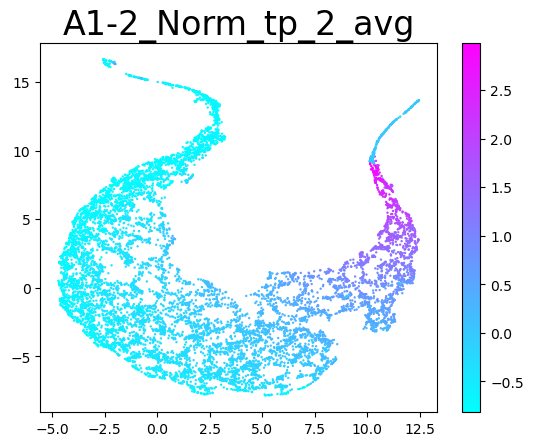

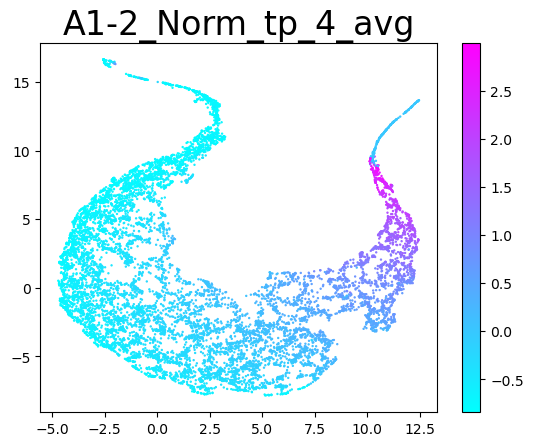

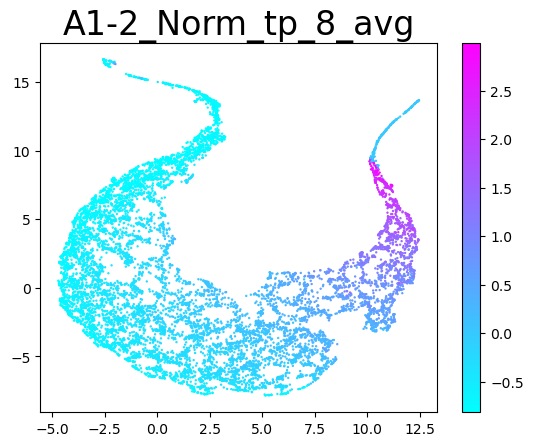

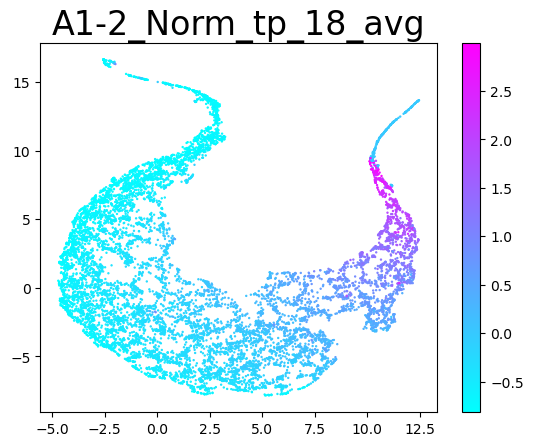

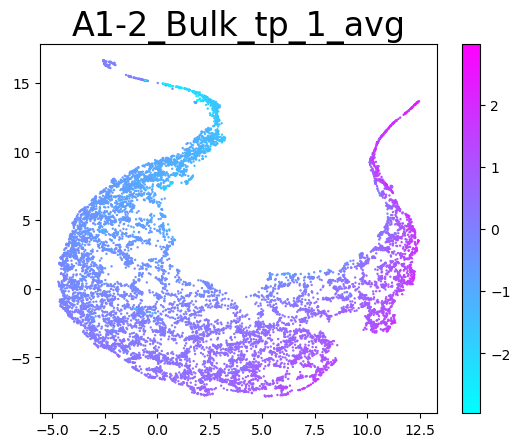

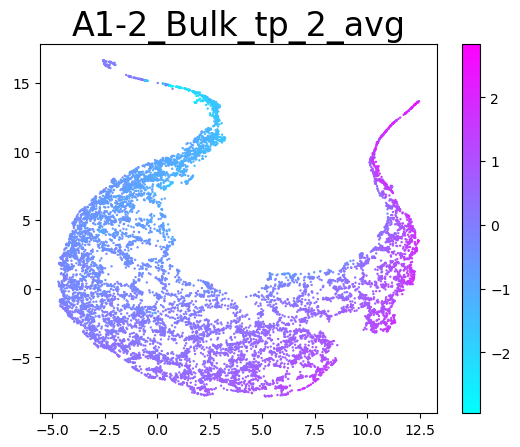

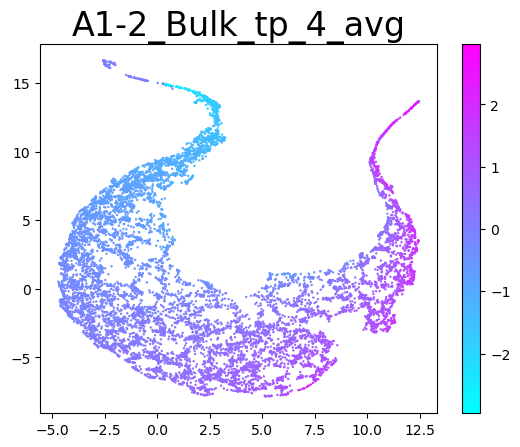

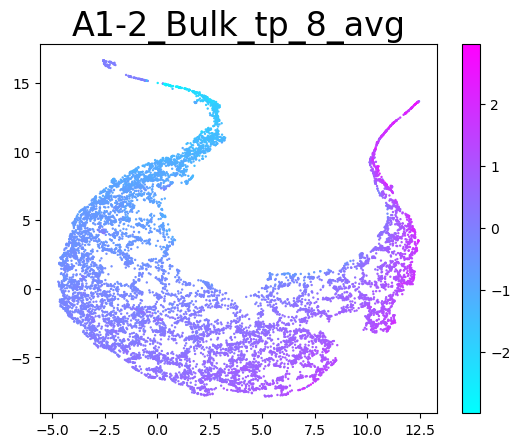

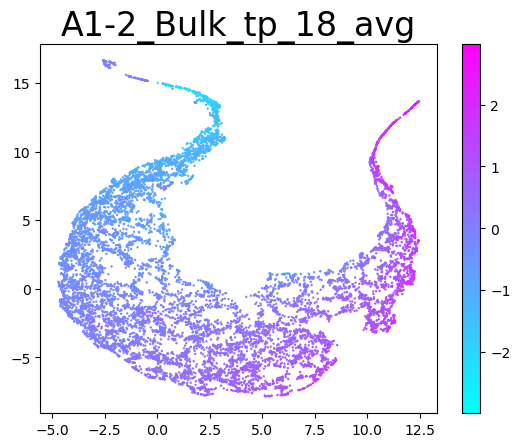

In [130]:
for col in raw_data.columns:
    c_map = stats.zscore(raw_data[col].values.astype(float))
    c_map[c_map > 3] = 0
    c_map[c_map < -3] = 0
    sc = plt.scatter(
        embedding2[:, 0],
        embedding2[:, 1],
        s=s_gene,
        c=c_map,
        cmap='cool')
    plt.colorbar(sc)
    plt.title(col, fontsize=24)
    plt.show()